# Legendre Memory Units
This is a PyTorch implementation of Legendre memory units, as presented in the [paper](https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks) by Voelker AR, Kajić I and Eliasmith C.  
SOTA performance on the psMNIST dataset is also reproduced.

## Start
To reset the notebook, run from this point

In [48]:
%reset -f

## Imports

In [49]:
import numpy as np

import torch
from torch import nn
from torch.nn import init
from torch.nn import functional as F

from scipy.signal import cont2discrete

## Functions

In [50]:
def leCunUniform(tensor):
    """ 
        LeCun Uniform Initializer
        References: 
        [1] https://keras.rstudio.com/reference/initializer_lecun_uniform.html
        [2] Source code of _calculate_correct_fan can be found in https://pytorch.org/docs/stable/_modules/torch/nn/init.html
        [3] Yann A LeCun, Léon Bottou, Genevieve B Orr, and Klaus-Robert Müller. Efficient backprop. In Neural networks: Tricks of the trade, pages 9–48. Springer, 2012
    """
    fan_in = init._calculate_correct_fan(tensor, "fan_in")
    limit = np.sqrt(3. / fan_in)
    init.uniform_(tensor, -limit, limit) # fills the tensor with values sampled from U(-limit, limit)

## Classes

### Single LMU Cell/Unit

In [51]:
class LMUCell(nn.Module):
    """ A single LMU Cell """


    def __init__(self, input_size, hidden_size, memory_size, theta, learn_a = False, learn_b = False, psmnist = False):
        """
        Parameters:
            input_size (int) : 
                Size of the input vector (x_t)
            hidden_size (int) : 
                Size of the hidden vector (h_t)
            memory_size (int) :
                Size of the memory vector (m_t)
            theta (int) :
                The number of timesteps in the sliding window that is represented using the LTI system
            learn_a (boolean) :
                Whether to learn the matrix A (default = False)
            learn_b (boolean) :
                Whether to learn the matrix B (default = False)
            psmnist (boolean) :
                Uses different parameter initializers when training on psMNIST (as specified in the paper)
        """
        
        super(LMUCell, self).__init__()

        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.f = nn.Tanh()

        A, B = self.stateSpaceMatrices(memory_size, theta)
        A = torch.from_numpy(A).float()
        B = torch.from_numpy(B).float()

        if learn_a:
            self.A = nn.Parameter(A)
        else:
            self.register_buffer("A", A)
    
        if learn_b:
            self.B = nn.Parameter(B)
        else:
            self.register_buffer("B", B)

        # Declare Model parameters:
        ## Encoding vectors
        self.e_x = nn.Parameter(torch.empty(1, input_size))
        self.e_h = nn.Parameter(torch.empty(1, hidden_size))
        self.e_m = nn.Parameter(torch.empty(1, memory_size))
        ## Kernels
        self.W_x = nn.Parameter(torch.empty(hidden_size, input_size))
        self.W_h = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.W_m = nn.Parameter(torch.empty(hidden_size, memory_size))

        self.initParameters(psmnist)


    def initParameters(self, psmnist = False):
        """ Initialize the cell's parameters """

        if psmnist:
            # Initialize encoders
            leCunUniform(self.e_x)
            init.constant_(self.e_h, 0)
            init.constant_(self.e_m, 0)
            # Initialize kernels
            init.constant_(self.W_x, 0)
            init.constant_(self.W_h, 0)
            init.xavier_normal_(self.W_m)
        else:
            # Initialize encoders
            leCunUniform(self.e_x)
            leCunUniform(self.e_h)
            init.constant_(self.e_m, 0)
            # Initialize kernels
            init.xavier_normal_(self.W_x)
            init.xavier_normal_(self.W_h)
            init.xavier_normal_(self.W_m)


    def stateSpaceMatrices(self, memory_size, theta):
        """ Returns the discretized state space matrices A and B """

        Q = np.arange(memory_size, dtype = np.float64).reshape(-1, 1)
        R = (2*Q + 1) / theta
        i, j = np.meshgrid(Q, Q, indexing = "ij")

        # Continuous
        A = R * np.where(i < j, -1, (-1.0)**(i - j + 1))
        B = R * ((-1.0)**Q)
        C = np.ones((1, memory_size))
        D = np.zeros((1,))

        # Convert to discrete
        A, B, C, D, dt = cont2discrete(
            system = (A, B, C, D), 
            dt = 1.0, 
            method = "zoh"
        )
        
        return A, B


    def forward(self, x, state):
        """
        Parameters:
            x (torch.tensor): 
                Input of size [batch_size, input_size]
            state (tuple): 
                h (torch.tensor) : [batch_size, hidden_size]
                m (torch.tensor) : [batch_size, memory_size]
        """

        h, m = state

        # Equation (7) of the paper
        u = F.linear(x, self.e_x) + F.linear(h, self.e_h) + F.linear(m, self.e_m) # [batch_size, 1]

        # Equation (4) of the paper
        m = F.linear(m, self.A) + F.linear(u, self.B) # [batch_size, memory_size]

        # Equation (6) of the paper
        h = self.f(
            F.linear(x, self.W_x) +
            F.linear(h, self.W_h) + 
            F.linear(m, self.W_m)
        ) # [batch_size, hidden_size]

        return h, m

### LMU Layer

In [52]:
class LMU(nn.Module):
    """ An LMU layer """

    def __init__(self, input_size, hidden_size, memory_size, theta, learn_a = False, learn_b= False, psmnist = False):
        """
        Parameters:
            input_size (int) : 
                Size of the input vector (x_t)
            hidden_size (int) : 
                Size of the hidden vector (h_t)
            memory_size (int) :
                Size of the memory vector (m_t)
            theta (int) :
                The number of timesteps in the sliding window that is represented using the LTI system
            learn_a (boolean) :
                Whether to learn the matrix A (default = False)
            learn_b (boolean) :
                Whether to learn the matrix B (default = False)
            psmnist (boolean) :
                Uses different parameter initializers when training on psMNIST (as specified in the paper)
        """

        super(LMU, self).__init__()
        self.hidden_size = hidden_size
        self.memory_size = memory_size
        self.cell = LMUCell(input_size, hidden_size, memory_size, theta, learn_a, learn_b, psmnist)


    def forward(self, x, state = None):
        """
        Parameters:
            x (torch.tensor): 
                Input of size [batch_size, seq_len, input_size]
            state (tuple) : (default = None) 
                h (torch.tensor) : [batch_size, hidden_size]
                m (torch.tensor) : [batch_size, memory_size]
        """
        
        # Assuming batch dimension is always first, followed by seq. length as the second dimension
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Initial state (h_0, m_0)
        if state == None:
            h_0 = torch.zeros(batch_size, self.hidden_size).to(DEVICE)
            m_0 = torch.zeros(batch_size, self.memory_size).to(DEVICE)
            state = (h_0, m_0)

        # Iterate over the timesteps
        output = []
        for t in range(seq_len):
            x_t = x[:, t, :] # [batch_size, input_size]
            h_t, m_t = self.cell(x_t, state)
            state = (h_t, m_t)
            output.append(h_t)

        output = torch.stack(output) # [seq_len, batch_size, hidden_size]
        output = output.permute(1, 0, 2) # [batch_size, seq_len, hidden_size]

        return output, state # state is (h_n, m_n) where n = seq_len

## Example: psMNIST

### Imports and Constants

In [53]:
import random
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [54]:
# Connect to GPU
if torch.cuda.is_available():
    DEVICE = "cuda"
    # Clear cache if non-empty
    torch.cuda.empty_cache()
    # See which GPU has been allotted 
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    DEVICE = "cpu"

Tesla T4


In [55]:
SEED = 0

def setSeed(seed):
    """ Set all seeds to ensure reproducibility """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

setSeed(SEED)

In [56]:
N_x = 1 # dimension of the input, a single pixel
N_t = 784
N_h = 212 # dimension of the hidden state
N_m = 256 # dimension of the memory
N_c = 10 # number of classes 
THETA = N_t
N_b = 100 # batch size
N_epochs = 10
LEARN_A = False
LEARN_B = False

### Data

In [57]:
class psMNIST(Dataset):
    """ Dataset that defines the psMNIST dataset, given the MNIST data and a fixed permutation """

    def __init__(self, mnist, perm):
        self.mnist = mnist # also a torch.data.Dataset object
        self.perm  = perm

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        unrolled = img.reshape(-1)
        permuted = unrolled[self.perm]
        permuted = permuted.reshape(-1, 1)
        return permuted, label

### Model

In [58]:
class Model(nn.Module):
    """ A simple model for the psMNIST dataset consisting of a single LMU layer and a single dense classifier """

    def __init__(self, input_size, output_size, hidden_size, memory_size, theta, learn_a = False, learn_b = False):
        super(Model, self).__init__()
        self.lmu = LMU(input_size, hidden_size, memory_size, theta, learn_a, learn_b, psmnist = True)
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lmu(x) # [batch_size, hidden_size]
        output = self.classifier(h_n)
        return output # [batch_size, output_size]

### Functions

#### Utils

In [83]:
def disp(img):
    """ Displays an image """
    if len(img.shape) == 3:
        img = img.squeeze(0)
    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [81]:
def dispSeq(seq, rows = 8):
    """ Displays a sequence of pixels """
    seq = seq.reshape(rows, -1) # divide the 1D sequence into `rows` rows for easy visualization
    disp(seq)

#### Model

In [61]:
def countParameters(model):
    """ Counts and prints the number of trainable and non-trainable parameters of a model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    print(f"The model has {trainable:,} trainable parameters and {frozen:,} frozen parameters")

In [62]:
def train(model, loader, optimizer, criterion):
    """ A single training epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.train()
    for batch, labels in tqdm(loader):

        torch.cuda.empty_cache()

        if batch.size(0) != N_b:
            continue

        batch = batch.to(DEVICE)
        labels = labels.long().to(DEVICE)

        optimizer.zero_grad()

        output = model(batch)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()

        preds  = output.argmax(dim = 1)
        y_pred += preds.tolist()
        y_true += labels.tolist()
        epoch_loss += loss.item()

    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

In [63]:
def validate(model, loader, criterion):
    """ A single validation epoch on the psMNIST data """

    epoch_loss = 0
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        for batch, labels in tqdm(loader):

            torch.cuda.empty_cache()

            if batch.size(0) != N_b:
                continue

            batch = batch.to(DEVICE)
            labels = labels.long().to(DEVICE)

            output = model(batch)
            loss = criterion(output, labels)
            
            preds  = output.argmax(dim = 1)
            y_pred += preds.tolist()
            y_true += labels.tolist()
            epoch_loss += loss.item()
            
    # Loss
    avg_epoch_loss = epoch_loss / len(loader)

    # Accuracy
    epoch_acc = accuracy_score(y_true, y_pred)

    return avg_epoch_loss, epoch_acc

### Main

#### Data

In [64]:
transform = transforms.ToTensor()
mnist_train = datasets.MNIST("/content/", train = True, download = True, transform = transform)
mnist_val   = datasets.MNIST("/content/", train = False, download = True, transform = transform)

perm = torch.load("permutation.pt").long() # created using torch.randperm(784)
ds_train = psMNIST(mnist_train, perm)
ds_val   = psMNIST(mnist_val, perm) 

dl_train = DataLoader(ds_train, batch_size = N_b, shuffle = True, num_workers = 2)
dl_val   = DataLoader(ds_val, batch_size = N_b, shuffle = True, num_workers = 2)

Label: 5


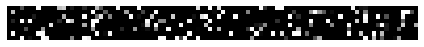

In [86]:
# Example of the data
eg_img, eg_label = ds_train[0]
print("Label:", eg_label)
dispSeq(eg_img)

#### Model

In [65]:
model = Model(
    input_size  = N_x,
    output_size = N_c,
    hidden_size = N_h, 
    memory_size = N_m, 
    theta = THETA, 
    learn_a = LEARN_A,
    learn_b = LEARN_B
)
model = model.to(DEVICE)

In [66]:
countParameters(model) # as stated in the paper, the model has ≈102K parameters

The model has 102,027 trainable parameters and 0 frozen parameters


#### Optimization

In [67]:
optimizer = optim.Adam(params = model.parameters())

In [68]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

In [69]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(N_epochs):
   
    print(f"Epoch: {epoch+1:02}/{N_epochs:02}")

    train_loss, train_acc = train(model, dl_train, optimizer, criterion)
    val_loss, val_acc = validate(model, dl_val, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%")
    print()

Epoch: 01/10



Train Loss: 0.715 | Train Acc: 76.95%
Val. Loss: 0.354 |  Val. Acc: 89.43%

Epoch: 02/10



Train Loss: 0.305 | Train Acc: 90.77%
Val. Loss: 0.229 |  Val. Acc: 93.25%

Epoch: 03/10



Train Loss: 0.207 | Train Acc: 93.63%
Val. Loss: 0.159 |  Val. Acc: 95.25%

Epoch: 04/10



Train Loss: 0.148 | Train Acc: 95.37%
Val. Loss: 0.147 |  Val. Acc: 95.48%

Epoch: 05/10



Train Loss: 0.118 | Train Acc: 96.33%
Val. Loss: 0.133 |  Val. Acc: 95.85%

Epoch: 06/10



Train Loss: 0.095 | Train Acc: 96.95%
Val. Loss: 0.115 |  Val. Acc: 96.53%

Epoch: 07/10



Train Loss: 0.075 | Train Acc: 97.63%
Val. Loss: 0.114 |  Val. Acc: 96.58%

Epoch: 08/10



Train Loss: 0.064 | Train Acc: 97.98%
Val. Loss: 0.102 |  Val. Acc: 96.85%

Epoch: 09/10



Train Loss: 0.055 | Train Acc: 98.28%
Val. Loss: 0.105 |  Val. Acc: 96.94%

Epoch: 10/10



Train Loss: 0.046 | Train Acc: 98.52%
Val. Loss: 0.112 |  Val. Acc: 96.55%



We can see that the network is achieving $> 96$% accuracy, which is state of the art performance on psMNIST

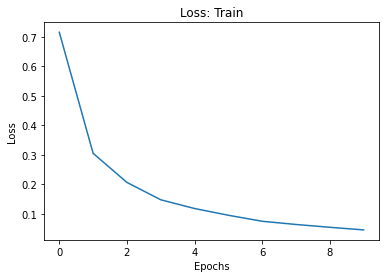

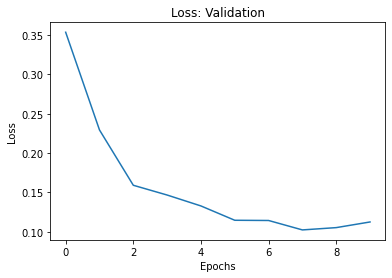

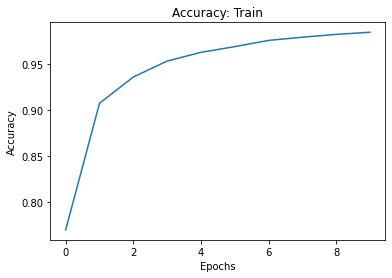

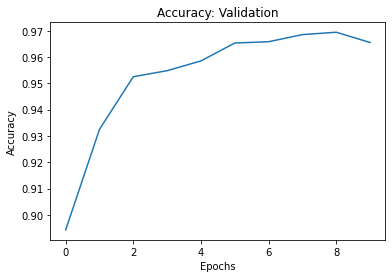

In [70]:
# Learning curves

plt.plot(range(len(train_losses)), train_losses)
plt.title("Loss: Train")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

plt.plot(range(len(val_losses)), val_losses)
plt.title("Loss: Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

plt.plot(range(len(train_accs)), train_accs)
plt.title("Accuracy: Train")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

plt.plot(range(len(val_accs)), val_accs)
plt.title("Accuracy: Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

## References
- [Legendre Memory Units: Continuous-Time
Representation in Recurrent Neural Networks](https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks)
- [Legendre Memory Units in NengoDL](https://www.nengo.ai/nengo-dl/examples/lmu.html)
- [nengo/keras-lmu](https://github.com/nengo/keras-lmu)